# Setup

In [1]:
# Import Packages

import os
import torch
if torch.backends.mps.is_available():
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# for data wrangling
import pandas as pd
import numpy as np

# for visaualization
import seaborn as sns
import matplotlib.pyplot as plt

# for model building
import re # for regular expression
from dotenv import load_dotenv
from openai import OpenAI

# for text processing
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
#from nltk.translate.bleu_score import sentence_bleu
#from sklearn.model_selection import train_test_split
#from nltk.translate.bleu_score import SmoothingFunction

In [2]:
# Set Device
# Set device to CUDA, if not to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Load & Preview Datasets

Rauh_Schwalbach_2020 - ParlSpeech V2 data: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/L4OAKN
Blumenau_2021 - House of Commons Parliamentary Debates data: https://reshare.ukdataservice.ac.uk/854292/

### **Rauh_Schwalbach_2020_ParlSpeech**

In [24]:
# Load Data
data_dir = os.path.join('..', 'data', '')

# Rauh_Schwalbach_2020_ParlSpeech
df_LibDem = pd.read_csv(data_dir + 'Rauh_Schwalbach_2020_ParlSpeech/df_LibDem.csv')
df_Con = pd.read_csv(data_dir + 'Rauh_Schwalbach_2020_ParlSpeech/df_Con.csv')
df_Lab = pd.read_csv(data_dir + 'Rauh_Schwalbach_2020_ParlSpeech/df_Lab.csv')


In [20]:
# What is the top 5 most frequent 'agenda' in the dataset?
print(df_LibDem['agenda'].value_counts().head(3))
print(df_Con['agenda'].value_counts().head(3))
print(df_Lab['agenda'].value_counts().head(3))

agenda
Business of the House                                       1074
Finance Bill                                                1002
Engagements [Oral Answers to Questions > Prime Minister]     730
Name: count, dtype: int64
agenda
Business of the House                                       20117
Engagements [Oral Answers to Questions > Prime Minister]    11849
Finance Bill                                                 3173
Name: count, dtype: int64
agenda
Business of the House                                       11751
Engagements [Oral Answers to Questions > Prime Minister]     7066
Business Of The House                                        5237
Name: count, dtype: int64


In [22]:
# What is the time frame of the 'date' in the dataset?
print(df_LibDem['date'].min(), df_LibDem['date'].max())
print(df_Con['date'].min(), df_Con['date'].max())
print(df_Lab['date'].min(), df_Lab['date'].max())

2000-01-10 2019-12-17
2000-01-10 2019-12-17
2000-01-10 2019-12-17


### **Blumenau_2021**

In [10]:
# Load Data (2015.csv)
data_dir = os.path.join('..', 'data', '')

# Blumenau_2021 - all Agenda
df_HoC_2015 = (pd.read_csv(data_dir + 'Blumenau_2021/2015.csv', parse_dates=['hdate'])
                   .loc[~pd.read_csv(data_dir + 'Blumenau_2021/2015.csv', 
                                     parse_dates=['hdate'])['parent']
                                     .str.contains('Oral Answers to Questions: ', na=False),  # Remove Oral Answers to Questions
                        ['epobject_id', 'name', 'constituency', 'age_years', 'gender', 'party_short', 
                         'hdate', 'body', 'parent', 'n_words', 'holds_government_position']])

C:\Users\chanho\AppData\Local\Temp\ipykernel_15700\2252780992.py:5: DtypeWarning: Columns (26,30,56,57,58,59,60,61,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df_HoC_2015 = (pd.read_csv(data_dir + 'Blumenau_2021/2015.csv', parse_dates=['hdate'])
C:\Users\chanho\AppData\Local\Temp\ipykernel_15700\2252780992.py:6: DtypeWarning: Columns (26,30,56,57,58,59,60,61,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  .loc[~pd.read_csv(data_dir + 'Blumenau_2021/2015.csv',


In [7]:
# Load Data (2016.csv)
data_dir = os.path.join('..', 'data', '')

# Blumenau_2021 - all Agenda
df_HoC_2016 = (pd.read_csv(data_dir + 'Blumenau_2021/2016.csv', parse_dates=['hdate'])
                   .loc[~pd.read_csv(data_dir + 'Blumenau_2021/2016.csv', 
                                     parse_dates=['hdate'])['parent']
                                     .str.contains('Oral Answers to Questions: ', na=False),  # Remove Oral Answers to Questions
                        ['epobject_id', 'name', 'constituency', 'age_years', 'gender', 'party_short', 
                         'hdate', 'body', 'parent', 'n_words', 'holds_government_position']])

C:\Users\chanho\AppData\Local\Temp\ipykernel_15700\956228394.py:5: DtypeWarning: Columns (26,30,60,61,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df_HoC_2016 = (pd.read_csv(data_dir + 'Blumenau_2021/2016.csv', parse_dates=['hdate'])
C:\Users\chanho\AppData\Local\Temp\ipykernel_15700\956228394.py:6: DtypeWarning: Columns (26,30,60,61,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  .loc[~pd.read_csv(data_dir + 'Blumenau_2021/2016.csv',


In [3]:
# Load Data (2019.csv)
data_dir = os.path.join('..', 'data', '')

# Blumenau_2021 - all Agenda
df_HoC_2019 = (pd.read_csv(data_dir + 'Blumenau_2021/2019.csv', parse_dates=['hdate'])
                   .loc[~pd.read_csv(data_dir + 'Blumenau_2021/2019.csv', 
                                     parse_dates=['hdate'])['parent']
                                     .str.contains('Oral Answers to Questions: ', na=False),  # Remove Oral Answers to Questions
                        ['epobject_id', 'name', 'constituency', 'age_years', 'gender', 'party_short', 
                         'hdate', 'body', 'parent', 'n_words', 'holds_government_position']])

C:\Users\chanho\AppData\Local\Temp\ipykernel_15700\2453094288.py:5: DtypeWarning: Columns (26,30,64,65,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df_HoC_2019 = (pd.read_csv(data_dir + 'Blumenau_2021/2019.csv', parse_dates=['hdate'])
C:\Users\chanho\AppData\Local\Temp\ipykernel_15700\2453094288.py:6: DtypeWarning: Columns (26,30,64,65,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  .loc[~pd.read_csv(data_dir + 'Blumenau_2021/2019.csv',


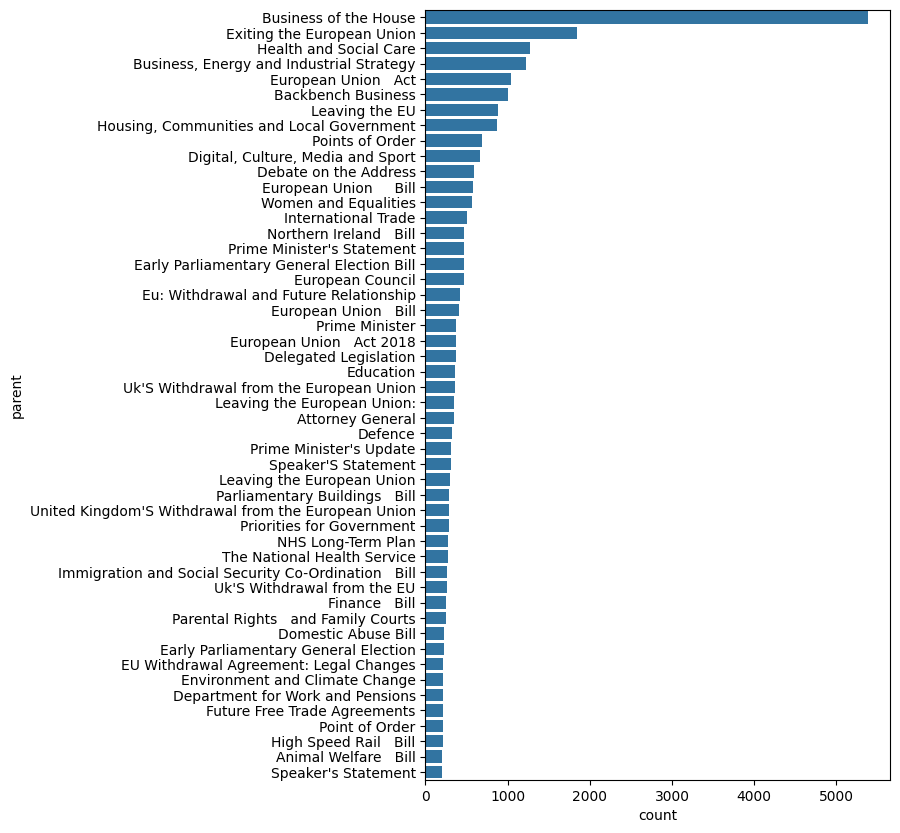

In [4]:
# What is the top most frequent 'agenda' in the dataset?
plt.figure(figsize=(6, 10))
sns.countplot(y='parent', data=df_HoC_2019, order=df_HoC_2019['parent'].value_counts().index[:50])
plt.show()

In [8]:
# Create a summary table of Agendas
df_agendasummary = (df_HoC_2019.groupby('parent').agg(n_speeches=('epobject_id', 'count'),
                                                n_words=('n_words', 'sum')).reset_index())
df_agendasummary

# Look for the word 'referendum' in the 'parent' column of 'df_HoC_2016'
df_HoC_2015

np.int64(1341)

## Subset Data

In [13]:
# Create Data Subset

# Function to create a subset based on the parent topic
def create_subset(dataset_path, parent_topic):
    df = pd.read_csv(data_dir + dataset_path, parse_dates=['hdate'])
    subset_df = df.query("parent == @parent_topic").loc[:, [
        'epobject_id', 'name', 'constituency', 'age_years', 'gender', 'party_short',
        'hdate', 'body', 'parent', 'n_words', 'holds_government_position'
    ]]
    return subset_df

# Function to create a subset based on the parent topic containing a specific string
def create_subset_containing(dataset_path, parent_strings):
    df = pd.read_csv(data_dir + dataset_path, parse_dates=['hdate'])
    # Create a regex pattern from the list of strings
    pattern = '|'.join(parent_strings)
    # Filter rows where 'parent' contains any of the specified strings
    subset_df = df[df['parent'].str.contains(pattern, case=True, na=False)].loc[:, [
        'epobject_id', 'name', 'constituency', 'age_years', 'gender', 'party_short',
        'hdate', 'body', 'parent', 'n_words', 'holds_government_position'
    ]]
    return subset_df


In [ ]:
# Create subsets for the following topics
df_HoC_2016_EuAff = create_subset('Blumenau_2021/2016.csv', 'European Affairs')
df_HoC_2016_EC = create_subset('Blumenau_2021/2016.csv', 'European Council')

df_HoC_2019_BoH = create_subset('Blumenau_2021/2019.csv', 'Business of the House')
df_HoC_2019_ExitEU = create_subset('Blumenau_2021/2019.csv', 'Exiting the European Union')
df_HoC_2019_HSC = create_subset('Blumenau_2021/2019.csv', 'Health and Social Care')
df_HoC_2019_EUA = create_subset('Blumenau_2021/2019.csv', 'European Union   Act')

df_HoC_2015_EUR = create_subset_containing('Blumenau_2021/2015.csv', ['European Union'])
df_HoC_2019_EU = create_subset_containing('Blumenau_2021/2019.csv', parent_strings = ['European Union', 'EU', 'Eu:'])
df_HoC_2019_Immigration = create_subset_containing('Blumenau_2021/2019.csv', parent_strings = ['Immigration'])
df_HoC_2019_NHS = create_subset_containing('Blumenau_2021/2019.csv', parent_strings = ['NHS'])

# Save the subsets df_HoC_2016_EuAff and df_HoC_2016_EC
df_HoC_2015_EUR.to_csv(data_dir + 'Blumenau_2021/2015_EUR.csv', index=False)
df_HoC_2016_EuAff.to_csv(data_dir + 'Blumenau_2021/df_HoC_2016_EuAff.csv', index=False)
df_HoC_2016_EC.to_csv(data_dir + 'Blumenau_2021/df_HoC_2016_EC.csv', index=False)

In [85]:
# Load the subsets df_HoC_2016_EuAff and df_HoC_2016_EC
df_HoC_2016_EuAff = pd.read_csv(data_dir + 'Blumenau_2021/df_HoC_2016_EuAff.csv', parse_dates=['hdate'])
df_HoC_2016_EC = pd.read_csv(data_dir + 'Blumenau_2021/df_HoC_2016_EC.csv', parse_dates=['hdate'])


## European Union

In [59]:
# What is the top most frequent 'agenda' in the dataset df_HoC_EU_2019
print(df_HoC_EU_2019['parent'].value_counts().head(5))

parent
Exiting the European Union                1841
European Union   Act                      1046
Leaving the EU                             880
European Union     Bill                    576
Eu: Withdrawal and Future Relationship     417
Name: count, dtype: int64


In [ ]:
df_HoC_2016_EuAff

## Business of the House

<Axes: xlabel='n_words', ylabel='Count'>

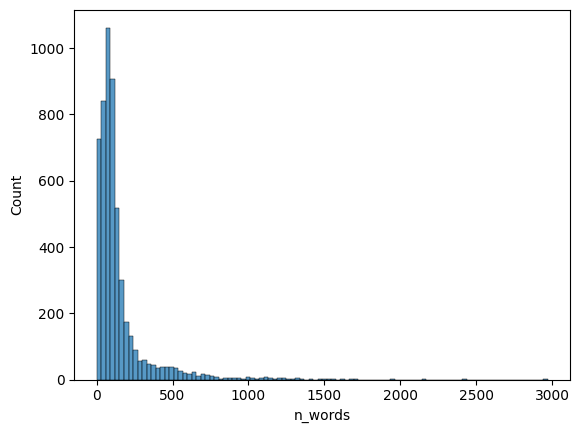

In [5]:
# What is distribution of 'n_words' in the dataset
sns.histplot(df_HoC_BoH_2019['n_words'], bins=100)

In [6]:
# What is the distribution of 'party_short' in the dataset
df_HoC_BoH_2019['party_short'].value_counts()

party_short
Conservative                         2948
Labour                               1266
Other                                 591
SNP                                   458
LibDem                                 71
The Independent Group for Change       40
Green                                   9
Change UK - The Independent Group       4
Name: count, dtype: int64

<Axes: xlabel='month_year'>

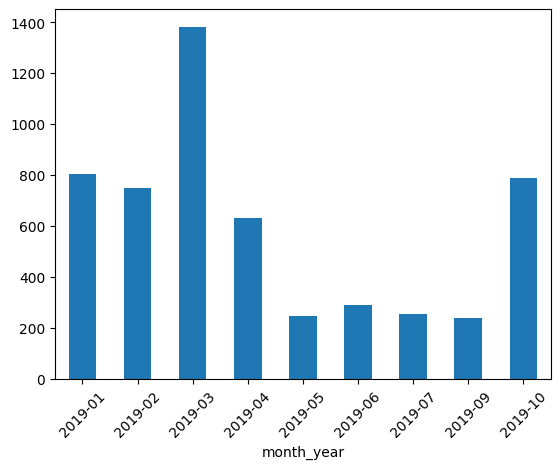

In [41]:
# What is the frequencey of speech of each day
#print(df_HoC_BoH_2019['hdate'].value_counts().sort_index())

# Visualize barplot the frequencey of speech of each month, 45 degree slanted x-axis
df_HoC_BoH_2019['hdate'] = pd.to_datetime(df_HoC_BoH_2019['hdate'])
df_HoC_BoH_2019['month'] = df_HoC_BoH_2019['hdate'].dt.month
df_HoC_BoH_2019['year'] = df_HoC_BoH_2019['hdate'].dt.year
df_HoC_BoH_2019['month_year'] = df_HoC_BoH_2019['hdate'].dt.to_period('M')
df_HoC_BoH_2019['month_year'] = df_HoC_BoH_2019['month_year'].dt.to_timestamp()
df_HoC_BoH_2019['month_year'] = df_HoC_BoH_2019['month_year'].dt.strftime('%Y-%m')

df_HoC_BoH_2019['month_year'].value_counts().sort_index().plot(kind='bar', rot=45)


In [8]:
# Subset the data 

# 2019, Feb-07
df_HoC_BoH_2019_Feb07 = df_HoC_BoH_2019.query("hdate == '2019-02-07' & party_short != 'Other'")

# 2019 March
df_HoC_BoH_2019_March = df_HoC_BoH_2019.query("hdate >= '2019-03-01' & hdate <= '2019-03-31' & party_short != 'Other'")

# 2019 April
df_HoC_BoH_2019_April = df_HoC_BoH_2019.query("hdate >= '2019-04-01' & hdate <= '2019-04-30' & party_short != 'Other'")
df_HoC_BoH_2019_April = df_HoC_BoH_2019_April[df_HoC_BoH_2019_April['n_words'] >= 25]


C:\Users\chanho\AppData\Local\Temp\ipykernel_13120\1536330600.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_HoC_BoH_2019_Feb07 = df_HoC_BoH_2019.query("hdate == '2019-02-07' & party_short != 'Other'")


# Text Classification Using ChatGPT

In [11]:
load_dotenv()
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
MODEL_gpt4o = 'gpt-4o-2024-08-06' # currently the latest version of GPT-4o (on 2024-09-25)
MODEL_gpt4o_mini = 'gpt-4o-mini'

## Zeroshot Classification

In [12]:
# Define Custom function:
from typing import List

def classify_text(texts: List[str], 
                  model: str, 
                  system_message,):

  # clean the text 
  texts = [re.sub(r'\s+', ' ', text).strip() for text in texts]

  # construct input

  messages = [
    # system prompt (modified to handle multiple inputs)
    {"role": "system", 
     "content": system_message},
    
    # user input
    {"role": "user", 
     "content": "\n".join(texts)},
  ]

  response = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0.0,
    seed=42,
    frequency_penalty=0,
    presence_penalty=0
  )
  
  result = response.choices[0].message.content
  
  return result.split("\n")

In [14]:
instructions = """
This task involves reading sentences from UK Parliamentary speech texts and judging whether these use Dimension Manipulation according to William H. Riker theory of Heresthetic.

## What is "Dimension Manipulation"?
According to William H. Riker theory of Heresthetic, Dimension Manipulation introduces new information & redefines Issues, which can be used to manipulate the outcome of a decision-making process. This involves either Increasing Dimensionality by expanding the Number of Issues Involved; or Fixing Dimensionality by Limiting the Number of Issues Involved.

## Your task
1. Carefully read the speech text, paying close attention to details.
2. Classify the speech as either Dimension Manipulation or No Dimension Manipulation

## Response format
Only respond with the chosen category and no additional text or explanations 
"""

### Classification for a Day

In [17]:
# Run Classification for 2019 Feb07
from tqdm.notebook import tqdm # for progress bar

texts = df_HoC_BoH_2019_Feb07['body'].tolist()
classifications_2019_Feb07 = [classify_text(text, model = MODEL_gpt4o_mini, 
                                 system_message=instructions) for text in tqdm(texts)]

  0%|          | 0/85 [00:00<?, ?it/s]

In [20]:
# Merge Classification Output with the Data
df_HoC_BoH_2019_Feb07_CL_mini = pd.concat([df_HoC_BoH_2019_Feb07.reset_index(drop=True), 
                                      pd.DataFrame(classifications_2019_Feb07, 
                                                   columns=['classification']) ], 
                                      axis=1)

In [19]:
# Save the Output
df_HoC_BoH_2019_Feb07_CL_mini.to_csv(data_dir + 'Blumenau_2021/df_HoC_BoH_2019_Feb07_CL_mini.csv', index=False)df_HoC_BoH_2019_Feb07_CL.to_csv(data_dir + 'Blumenau_2021/df_HoC_BoH_2019_Feb07_CL.csv', index=False)

In [23]:
# Compare Models

# Check if the classification is the same in df_HoC_BoH_2019_Feb07_CL and df_HoC_BoH_2019_Feb07_CL_mini, output if True
(df_HoC_BoH_2019_Feb07_CL['classification'] == df_HoC_BoH_2019_Feb07_CL_mini['classification']).all()


np.False_

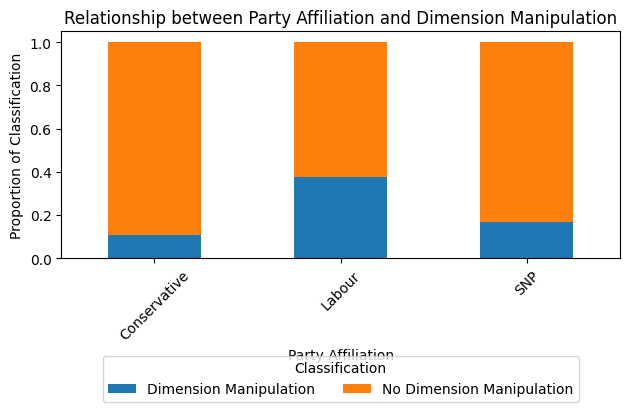

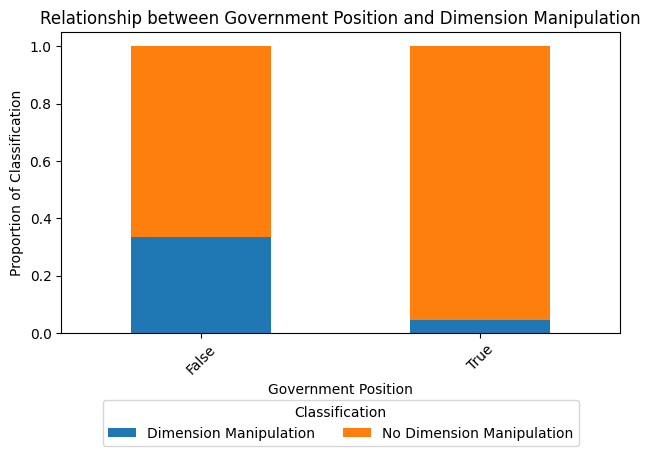

In [85]:
# Visualize Relationships
import matplotlib.pyplot as plt

# First plot: Relationship between 'party_short' and 'Dimension_Manipulation'
df_HoC_BoH_2019_Feb07_CL.groupby('party_short')['classification'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, rot=45)
plt.title('Relationship between Party Affiliation and Dimension Manipulation')  # Add appropriate title
plt.xlabel('Party Affiliation')  # Label x-axis
plt.ylabel('Proportion of Classification')  # Label y-axis
plt.legend(title='Classification', loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)  # Adjust legend position and add a title
plt.tight_layout()  # Ensure layout is adjusted
plt.show()

# Second plot: Relationship between 'holds_government_position' and 'Dimension_Manipulation'
df_HoC_BoH_2019_Feb07_CL.groupby('holds_government_position')['classification'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, rot=45)
plt.title('Relationship between Government Position and Dimension Manipulation')  # Add appropriate title
plt.xlabel('Government Position')  # Label x-axis
plt.ylabel('Proportion of Classification')  # Label y-axis
plt.legend(title='Classification', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)  # Adjust legend position and add a title
plt.tight_layout()  # Ensure layout is adjusted
plt.show()


### Classification for a Month

In [ ]:
# Run Classification for 2019 April
from tqdm.notebook import tqdm # for progress bar

# Filter out 'n_words' < 25 from 'df_HoC_BoH_2019_April'
texts = df_HoC_BoH_2019_April[df_HoC_BoH_2019_April['n_words'] >= 25]['body'].tolist()
classifications_2019_April = [classify_text(text, model=MODEL, 
                                 system_message=instructions) for text in tqdm(texts)]

In [81]:
# Merge Classification Output with the Data
df_HoC_BoH_2019_April_CL = pd.concat([df_HoC_BoH_2019_April.reset_index(drop=True), 
                                      pd.DataFrame(classifications_2019_April, 
                                                   columns=['classification']) ], 
                                      axis=1)

In [ ]:
# Save the Output
df_HoC_BoH_2019_April_CL.to_csv(data_dir + 'Blumenau_2021/df_HoC_BoH_2019_April_CL.csv', index=False)

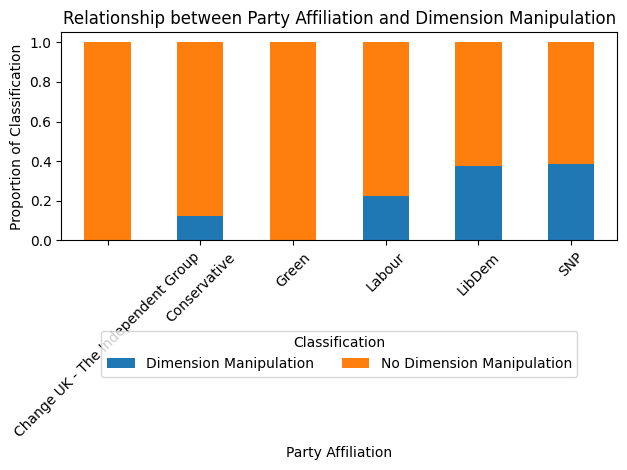

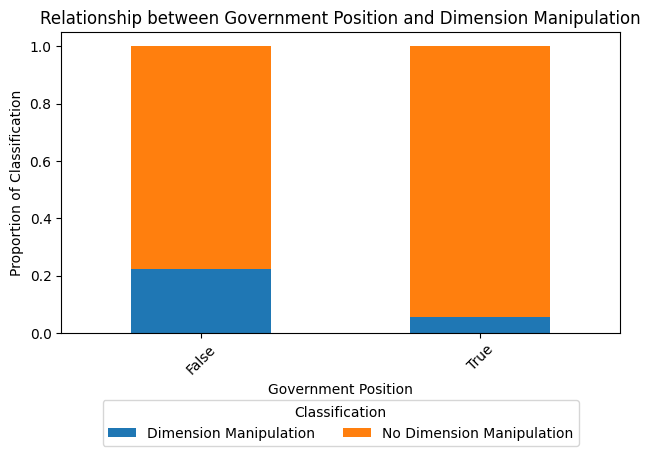

In [86]:
# Visualize Relationships
import matplotlib.pyplot as plt

# First plot: Relationship between 'party_short' and 'Dimension_Manipulation'
df_HoC_BoH_2019_April_CL.groupby('party_short')['classification'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, rot=45)
plt.title('Relationship between Party Affiliation and Dimension Manipulation')  # Add appropriate title
plt.xlabel('Party Affiliation')  # Label x-axis
plt.ylabel('Proportion of Classification')  # Label y-axis
plt.legend(title='Classification', loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)  # Adjust legend position and add a title
plt.tight_layout()  # Ensure layout is adjusted
plt.show()

# Second plot: Relationship between 'holds_government_position' and 'Dimension_Manipulation'
df_HoC_BoH_2019_April_CL.groupby('holds_government_position')['classification'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, rot=45)
plt.title('Relationship between Government Position and Dimension Manipulation')  # Add appropriate title
plt.xlabel('Government Position')  # Label x-axis
plt.ylabel('Proportion of Classification')  # Label y-axis
plt.legend(title='Classification', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)  # Adjust legend position and add a title
plt.tight_layout()  # Ensure layout is adjusted
plt.show()


## Oneshot Classification

In [ ]:
instructions = """
This task involves reading sentences from UK Parliamentary speech texts and judging whether these use Dimension Manipulation according to William H. Riker theory of Heresthetic.

## What is "Dimension Manipulation"?
According to William H. Riker theory of Heresthetic, Dimension Manipulation introduces new information & redefines Issues, which can be used to manipulate the outcome of a decision-making process. This involves either Increasing Dimensionality by expanding the Number of Issues Involved; or Fixing Dimensionality by Limiting the Number of Issues Involved.

## Your task
1. Carefully read the speech text, paying close attention to details.
2. Classify the speech as either Dimension Manipulation or No Dimension Manipulation

## Response format
Only respond with the chosen category and no additional text or explanations 
"""